In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('0711_Landata.csv')

data = data.sort_values(by=['Rank'])

data.head()

,Unnamed: 0,Rank,都市土地使用分區_空值,一般農業區,住,其他,商,山坡地保育區,工,工業區,...,露台,通道,車庫,陽台,屋頂突出物,儲藏室,車位總價,lat,lng,總價元
8506,8506,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.061855,0.634850,1805275500
33654,33654,2,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.008934,0.485005,1450000000
54521,54521,3,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.088486,0.441842,1380000000
10655,10655,4,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,0.000000,0.000000,1112000000
47147,47147,5,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.52118,1.058463,0.465010,1050000000


rank前1000做traing, 500做validation

In [113]:
data_1000 = data[:1000]
val_500 = data[1000:1500]

In [115]:
train_x = data_1000.drop(['Unnamed: 0', 'Rank', '總價元'], axis=1).reset_index(drop=True)
train_y = data_1000['Rank'].copy().reset_index(drop=True)
test_x = val_500.drop(['Unnamed: 0', 'Rank', '總價元'], axis=1).reset_index(drop=True)
test_y = val_500['Rank'].copy().reset_index(drop=True)

In [116]:
import itertools
index = np.array(list(itertools.permutations(np.arange(1000), 2)))
index_test = np.array(list(itertools.permutations(np.arange(500), 2)))
np.random.shuffle(index)
np.random.shuffle(index_test)

In [117]:
sample_size = 10000
selected = np.random.choice(index.shape[0], sample_size)
select_test = np.random.choice(index_test.shape[0], sample_size)
index = index[selected]
index_test = index_test[select_test]

In [118]:
def target(I, J):
    target = np.subtract(I, J) 
    # sign => 大於 0為1, clip => 限制在0, 1
    target = np.clip(np.sign(target), 0, 1)
    return target

target_train = target(train_y.iloc[index[:,0]], train_y.iloc[index[:,1]])
target_test = target(test_y.iloc[index_test[:,0]], test_y.iloc[index_test[:,1]])

In [124]:
from keras.models import Sequential, Model
from keras.layers import Dense, Subtract, Activation, Input
import keras.optimizers

feature_num = train_x.shape[1]
marker = Sequential()
marker.add(Dense(256, activation='relu', input_shape=(feature_num,)))
marker.add(Dense(128, activation='relu'))
marker.add(Dense(64, activation='relu'))
marker.add(Dense(1, activation='linear'))

i_input = Input(shape=(feature_num,))
j_input = Input(shape=(feature_num,))
i_score = marker(i_input)
j_score = marker(j_input)

diff = Subtract()([i_score, j_score])
output = Activation('sigmoid')(diff)

ranknet = Model([i_input, j_input], output)
optimizer = keras.optimizers.Adam(lr=1e-3, decay=0.0)
ranknet.summary()
ranknet.compile(optimizer = optimizer, loss = "binary_crossentropy",metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 119)          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 119)          0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 1)            71937       input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
subtract_15 (Subtract)          (None, 1)            0           sequential_13[1][0]              
          

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
 - 0s - loss: 0.1417 - acc: 0.9432 - val_loss: 1.5568 - val_acc: 0.5425
Epoch 2/10
 - 0s - loss: 0.1260 - acc: 0.9480 - val_loss: 1.5994 - val_acc: 0.5509
Epoch 3/10
 - 0s - loss: 0.1193 - acc: 0.9530 - val_loss: 1.6514 - val_acc: 0.5474
Epoch 4/10
 - 0s - loss: 0.1152 - acc: 0.9531 - val_loss: 1.6902 - val_acc: 0.5487
Epoch 5/10
 - 0s - loss: 0.1117 - acc: 0.9552 - val_loss: 1.7446 - val_acc: 0.5493
Epoch 6/10
 - 0s - loss: 0.1092 - acc: 0.9555 - val_loss: 1.7753 - val_acc: 0.5472
Epoch 7/10
 - 0s - loss: 0.1070 - acc: 0.9576 - val_loss: 1.8244 - val_acc: 0.5512
Epoch 8/10
 - 0s - loss: 0.1053 - acc: 0.9578 - val_loss: 1.8558 - val_acc: 0.5509
Epoch 9/10
 - 0s - loss: 0.1034 - acc: 0.9591 - val_loss: 1.8845 - val_acc: 0.5519
Epoch 10/10
 - 0s - loss: 0.1019 - acc: 0.9599 - val_loss: 1.9148 - val_acc: 0.5466


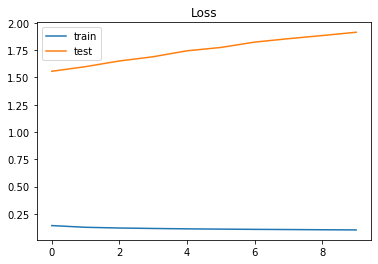

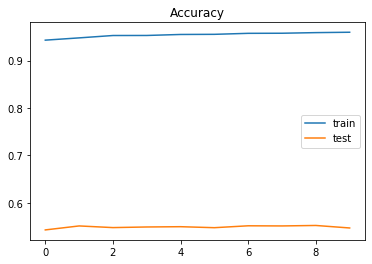

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
EPOCHS = 10
BATCH_SIZE = 300
model_history = ranknet.fit([train_x.iloc[index[:,0]], train_x.iloc[index[:,1]]], target_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_data=([test_x.iloc[index_test[:,0]], test_x.iloc[index_test[:,1]]], target_test), verbose=2)

plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(model_history.history['acc'], label='train')
plt.plot(model_history.history['val_acc'], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

In [131]:
marker.predict([test_x])[0]

array([4.5814157], dtype=float32)